### Time Series Forecasting

`Problem Statement`: To perform daily forecast for one month on stocks data

`Company`: Novo-Nordisk

Novo Nordisk manufactures and markets pharmaceutical products and services, specifically diabetes care medications and devices. 

`Data Range`: 10 years 

`Source`: Yahoo Finance
    https://sg.finance.yahoo.com/quote/NOVO-B.CO/history

#### 1. Install necessary libraries

In [1]:
!pip install yfinance --user

In [2]:
!pip install statsmodels --user

#### 2. Import required libraries and models

In [3]:
import yfinance as yf 
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as st
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

#### 3. Extract data 

Extracting last 10 years of stocks data.

2014 to Till date (date.today())

In [4]:
data = yf.download('NOVO-B.CO','2014-01-01',date.today())

[*********************100%%**********************]  1 of 1 completed


In [5]:
data.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-04,871.700012,874.299988,859.000000,860.599976,860.599976,2201258
2024-04-05,856.500000,870.000000,848.799988,867.500000,867.500000,2774059
2024-04-08,865.500000,874.900024,862.799988,871.599976,871.599976,1598156
2024-04-09,875.000000,877.900024,856.400024,857.700012,857.700012,1941371
2024-04-10,857.000000,866.000000,845.099976,866.000000,866.000000,1540552
2024-04-11,856.599976,873.500000,856.500000,869.299988,869.299988,2276247
2024-04-12,870.000000,891.900024,868.599976,880.000000,880.000000,2064725
2024-04-15,879.000000,888.000000,876.000000,879.200012,879.200012,1814697
2024-04-16,862.000000,872.099976,854.700012,867.500000,867.500000,1728440


#### 4. Exploratory Data Analysis

'Date' column has been already set to index.

In [6]:
data.isnull().sum().sum()

0

Null values are not found

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2572 entries, 2014-01-02 to 2024-04-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2572 non-null   float64
 1   High       2572 non-null   float64
 2   Low        2572 non-null   float64
 3   Close      2572 non-null   float64
 4   Adj Close  2572 non-null   float64
 5   Volume     2572 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 140.7 KB


In [8]:
data.index

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2024-04-04', '2024-04-05', '2024-04-08', '2024-04-09',
               '2024-04-10', '2024-04-11', '2024-04-12', '2024-04-15',
               '2024-04-16', '2024-04-17'],
              dtype='datetime64[ns]', name='Date', length=2572, freq=None)

In [9]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2.572000e+03
mean,256.440251,259.270315,253.710303,256.605171,240.410565,5.028926e+06
std,170.245949,172.427857,168.309616,170.551993,175.542686,2.759683e+06
min,100.000000,101.750000,99.000000,100.449997,80.917427,2.800000e+03
25%,151.212502,152.518745,149.768745,150.962502,133.240551,3.330513e+06
50%,186.000000,187.500000,183.724998,185.550003,158.280304,4.453595e+06
75%,318.412498,322.550011,315.074989,319.862503,308.632439,5.963490e+06
max,920.000000,932.000000,909.200012,924.500000,917.880920,4.282551e+07


In [10]:
print("Close: {0}, Open: {1}".format(data['Close'].var(),data['Open'].var()))

Close: 29087.98218221347, Open: 28983.683131097303


<AxesSubplot:xlabel='Date'>

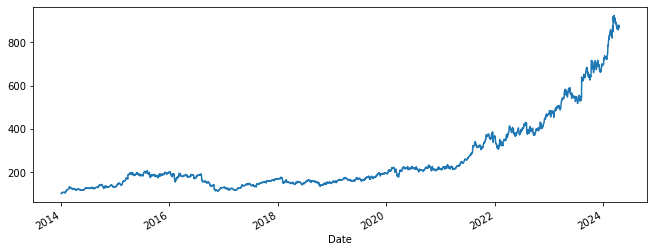

In [11]:
plt.figure(figsize=(10,6))
data['Close'].plot(figsize=(11,4))

#### 5. Decomposition 

As there is a increasing in trend, we would implement `Additive` model to decompose our data into components such as `Trend`, `Seasonal` and `Residual`

In [12]:
# Additive Decompositon
# 21 monthly working days (5 for each week)

add_result = seasonal_decompose(data['Close'], model = 'additive', period=22)
add_result

Text(0.5, 0.98, '\nAdditive Decompose')

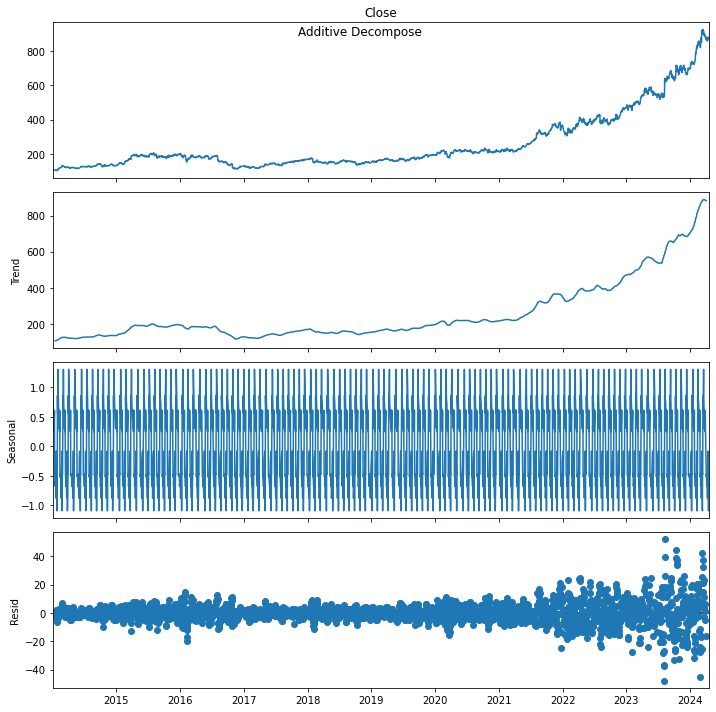

In [13]:
plt.rcParams.update({'figure.figsize': (10,10)})

add_result.plot().suptitle('\nAdditive Decompose', fontsize=12)

`Observation`: Data contains trend + seasonality + irregularity (over last 3 years)

#### 6. Stationarity check

`ADF Test` [Augmented Dickey-Fuller Test]

Null hypothesis: Data is non-stationary
Alternate hypothesis: Data is stationary

If p-value is <= 0.05 then 'Reject Null Hypothesis' 'Data will be declared as stationary.'

In [14]:
def adf(series):
    result = st.adfuller(series)
    print("P-value: {}".format(result[1]))
    if result[1] <= 0.05:
        print("Is stationary")
    else:
        print("Not stationary")

`KPSS Test` [Kwiatkowski-Phillips-Schmidt-Shin Test]

Null hypothesis: Data is stationary
Alternate hypothesis: Data is non-stationary

If p-value is > 0.05 then 'Reject Null Hypothesis' 'Data will be declared as stationary.'

In [15]:
def kpss(series):
    kpss_p_value = st.kpss(series)[1]
    print("P-value: ",kpss_p_value)
    if kpss_p_value < 0.05:
        print("Data is non-stationary.")
    else:
        print("Data is Stationary.")

In [16]:
adf(data['Close'])

P-value: 1.0
Not stationary


In [17]:
kpss(data['Close'])

P-value:  0.01
Data is non-stationary.


<ipython-input-15-df26df29d3f2>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = st.kpss(series)[1]


`Observation`: Both ADF and KPSS test verfies that data is non-stationary

#### 7. Differencing

To stabilise mean of the data

In [18]:
data['First_differencing'] = data['Close'].diff(periods=1)

In [19]:
adf(data['First_differencing'].dropna())

P-value: 2.972372639414696e-13
Is stationary


In [20]:
kpss(data['First_differencing'].dropna())

P-value:  0.01
Data is non-stationary.


<ipython-input-15-df26df29d3f2>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = st.kpss(series)[1]


`Observation`: Only ADF test verfies but KPSS test doesn't.

Hence, increase the order of differencing till stationarity is achieved.

In [21]:
data['differencing'] = data['Close'].diff(periods=25)

In [22]:
adf(data['differencing'].dropna())

P-value: 2.0237043331337248e-08
Is stationary


In [23]:
kpss(data['differencing'].dropna())

P-value:  0.01
Data is non-stationary.


<ipython-input-15-df26df29d3f2>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = st.kpss(series)[1]


`Observation`: Stationarity hasn't been able to achieve by differencing.

#### 8. Data Distribution

<AxesSubplot:xlabel='Close', ylabel='Count'>

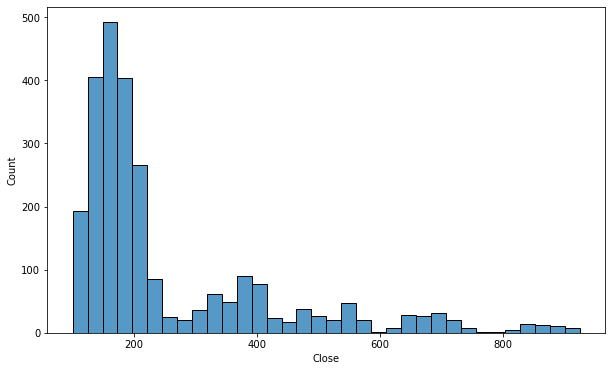

In [24]:
plt.figure(figsize=(10,6))
sns.histplot(data['Close'])

Data has `Right Skewed` distribution.

#### 9. Log Transformation

To stabilise variance of the data

In [25]:
data['Log_transformed'] = np.log(data["Close"])

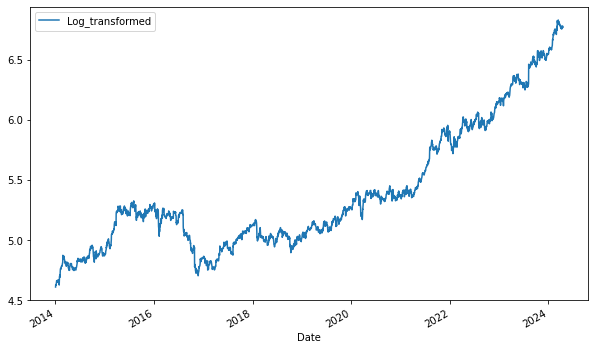

In [26]:
plt.figure(figsize=(10,6))
data['Log_transformed'].plot()
plt.legend()
plt.show()

In [27]:
adf(data['Log_transformed'].dropna())

P-value: 0.9905649997778474
Not stationary


In [28]:
kpss(data['Log_transformed'].dropna())

P-value:  0.01
Data is non-stationary.


<ipython-input-15-df26df29d3f2>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = st.kpss(series)[1]


Performing 1 order differencing on transformed data

In [29]:
data['Log_diff_1'] = data['Log_transformed'].diff(periods=1)

In [30]:
adf(data['Log_diff_1'].dropna())

P-value: 0.0
Is stationary


In [31]:
kpss(data['Log_diff_1'].dropna())

P-value:  0.1
Data is Stationary.


<ipython-input-15-df26df29d3f2>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = st.kpss(series)[1]


`Observation`: Data is stationary and is verfied.

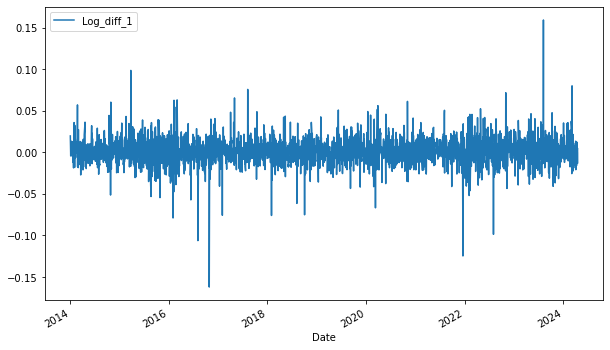

In [32]:
plt.figure(figsize=(10,6))
data['Log_diff_1'].plot()
plt.legend()
plt.show()

#### 10. ACF and PACF plot

PACF - `p` - AR.  
ACF - `q` - MA

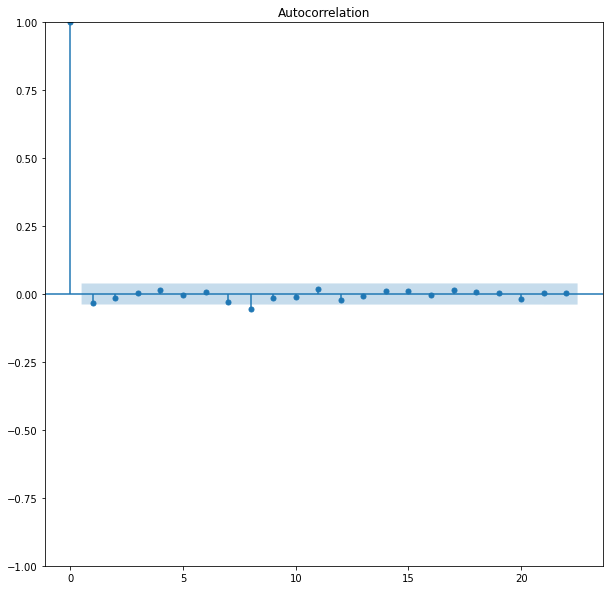

In [33]:
acf = plot_acf(data['Log_diff_1'].dropna(),lags=22)

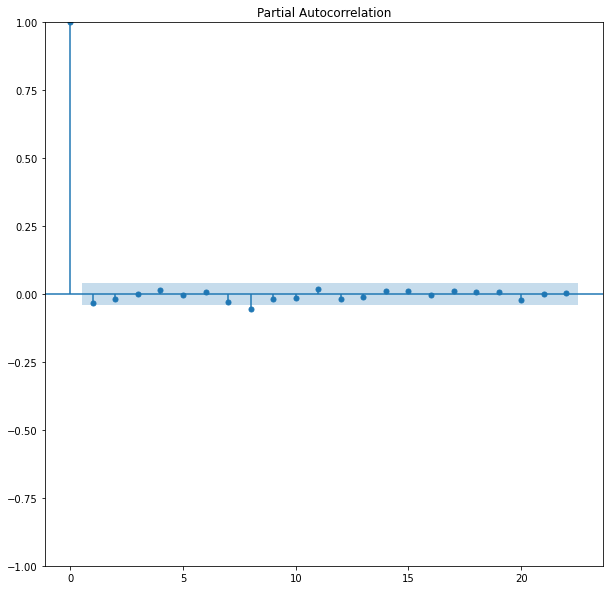

In [34]:
pacf = plot_pacf(data['Log_diff_1'].dropna(),lags=22)

`Observation`: 'p' and 'q' values are 2 and 3 repectively.

#### 11. Splitting of Data

Train and Test data - 80:20 ratio

In [35]:
close = data['Close']
size = int(len(close)*0.8)
train, test = close.iloc[:size], close[size:]

In [36]:
p,d,q = 2,1,3

#### 12. Model fitting

`Model 1`: ARIMA 

In [37]:
model = ARIMA(train, order=(p,d,q))
arima_model = model.fit()
print(arima_model.summary())

C:\Users\rr14\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rr14\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rr14\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rr14\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as st

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2057
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -5368.948
Date:                Thu, 18 Apr 2024   AIC                          10749.896
Time:                        20:36:59   BIC                          10783.667
Sample:                             0   HQIC                         10762.279
                               - 2057                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3060      0.065    -20.225      0.000      -1.433      -1.179
ar.L2         -0.8125      0.060    -13.468      0.000      -0.931      -0.694
ma.L1          1.3000      0.066     19.731      0.0

In [38]:
predictions = arima_model.predict(start = len(train), end = len(train)+len(test)-1)

C:\Users\rr14\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rr14\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [39]:
predictions

2057    364.964196
2058    364.110428
2059    364.401124
2060    364.715182
2061    364.068821
           ...    
2567    364.426091
2568    364.426091
2569    364.426091
2570    364.426091
2571    364.426091
Name: predicted_mean, Length: 515, dtype: float64

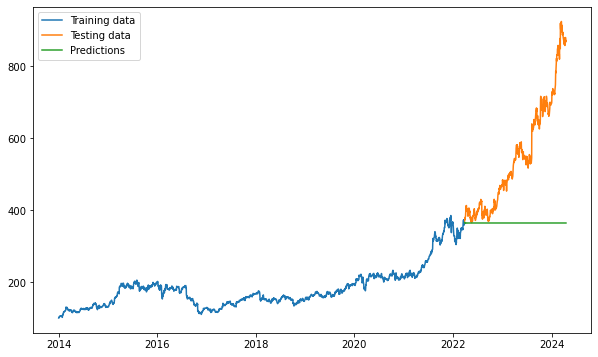

In [40]:
train_index = train.index.to_numpy()
test_index = test.index.to_numpy()

plt.figure(figsize=(10,6))
plt.plot(train_index, train.values, label='Training data')
plt.plot(test_index, test.values, label='Testing data')
plt.plot(test_index, predictions.values, label='Predictions')
plt.legend()
plt.show()

Forecasting using ARIMA model

In [41]:
forecast = arima_model.forecast(steps=21)

C:\Users\rr14\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rr14\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


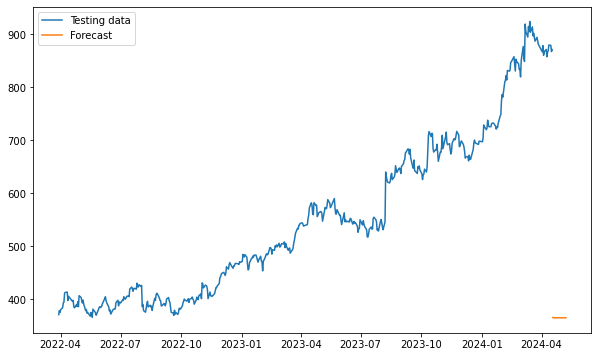

In [42]:
forecast_index = pd.date_range(test_index[-1], periods=22)[1:].to_numpy()

plt.figure(figsize=(10,6))
plt.plot(test_index, test.values, label='Testing data')
plt.plot(forecast_index, forecast.values, label='Forecast')
plt.legend()
plt.show()

`Model 2`: SARIMAX 

In [43]:
sarima_model = SARIMAX(train, order=(2,1,3), seasonal_order=(2,1,3,12))
sarima = sarima_model.fit()

C:\Users\rr14\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rr14\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rr14\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [44]:
sarimax_predictions = sarima.predict(start = len(train), end = len(train)+len(test)-1)

C:\Users\rr14\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rr14\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


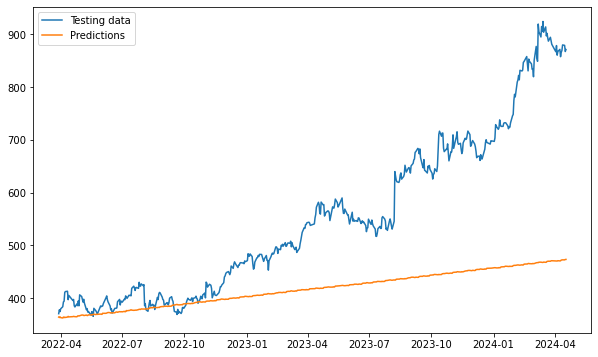

In [45]:
plt.figure(figsize=(10,6))
plt.plot(test_index, test.values, label='Testing data')
plt.plot(test_index, sarimax_predictions.values, label='Predictions')
plt.legend()
plt.show()

Forecasting using SARIMAX

C:\Users\rr14\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rr14\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


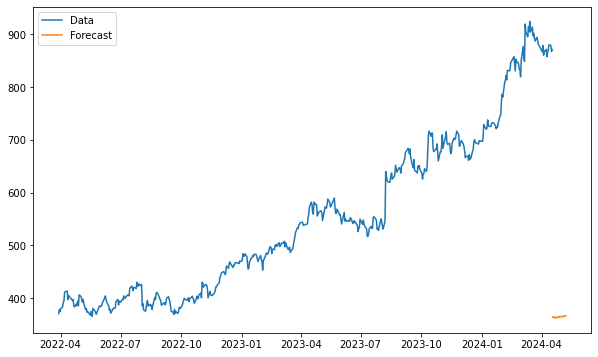

In [46]:
sarima_forecast = sarima.forecast(steps = 21)
forecast_index_sarimax = pd.date_range(test_index[-1], periods=21+1)[1:].to_numpy()

plt.figure(figsize=(10,6))
plt.plot(test_index, test.values, label='Data')
plt.plot(forecast_index_sarimax, sarima_forecast.values, label='Forecast')
plt.legend()
plt.show()

#### 13. Model Evaluation

ARIMA model evaluation

In [47]:
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)

print(f'Mean Squared Error (MSE): {mse: .2f}')
print(f'Root Mean Squared Error (RMSE): {rmse: .2f}')
print(f'Mean Absolute Error (MAE): {mae: .2f}')

Mean Squared Error (MSE):  58061.49
Root Mean Squared Error (RMSE):  240.96
Mean Absolute Error (MAE):  186.97


SARIMAX model evaluation

In [48]:
mse = mean_squared_error(test, sarimax_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, sarimax_predictions)

print(f'Mean Squared Error (MSE): {mse: .2f}')
print(f'Root Mean Squared Error (RMSE): {rmse: .2f}')
print(f'Mean Absolute Error (MAE): {mae: .2f}')

Mean Squared Error (MSE):  32852.06
Root Mean Squared Error (RMSE):  181.25
Mean Absolute Error (MAE):  134.83


`Final Observation`: SARIMAX works little better than ARIMA as data contains seasonality.